# Using label-studio for rapid annotation of geospatial data for airborne environmental monitoring

Environmental remote sensing using airborne image capture allows unprecedented insight into the distribution and abundance of organisms on earth. To detect and classify objects in airborne imagery, machine learning tools need to label the location and classes of objects. Here at the Weecology Lab at the University of Florida, we use label-studio to annotate airborne imagery for a variety of geospatial tasks, including tree detection in very high resolution orthophotos, and bird classification in UAV orthomosaics. Label-studio’s web interface has been key in creating labels for our machine learning workflow and keep our distributed team on the same page. Machine learning models for airborne object detection and classification require thousands of labels to create accurate detection models. In this post, I provide some key steps and uses for geospatial data labeling in label studio.

1. Converting large geospatial tiles into smaller crops in a format compatible with label-studio?
2. Creating a bounding box annotation project using the label-studio python-sdk
3. Placing pre-annotated images into label-studio using existing foundation models

The data comes from our work surveying bird colonies to support everglades restoration efforts using Unpiloted Aerial Vehivles (UAV). Let’s look at an orthomosaic image of one of those colonies. We also make use of our [DeepForest python package](https://deepforest.readthedocs.io/en/latest/), a tool for airborne model training focused on ecological monitoring. 

![Figure 1](public/Figure1.jpg)

# Prerequisites

* A working version of label-studio up and running. For this tutorial we will be serving local studio, start label studio from terminal
```
label-studio
```
see below for making sure to set proper env variables for local serving.

Here is a video of me doing that!

**_NOTE:_**  We are serving local files and using the python SDK. Label-studio is generally setup to use cloud storage and you need to allow local file serving just for this tutorial, see https://labelstud.io/guide/start#Set_environment_variables. I found this process a little frustrating, so I made a video. In the video I also show how we can set up a storage sync location. 

<div>
    <a href="https://www.loom.com/share/18017f925b054f6d9290622be7b559f9">
      <p>Starting Label Studio with Local File Storage - Watch Video</p>
    </a>
    <a href="https://www.loom.com/share/18017f925b054f6d9290622be7b559f9">
      <img style="max-width:300px;" src="https://cdn.loom.com/sessions/thumbnails/18017f925b054f6d9290622be7b559f9-with-play.gif">
    </a>
  </div>
  
* pip install DeepForest

## Preparing geospatial data for labeling

### Tiling orthomosaics into manageable pieces

This orthomosaic has been georectified, meaning that the pixels in the imagery correspond to locations on the earth’s surface. While this is crucial for matching images among surveys, or associating images with other data products, it presents a couple challenges for standard annotation workflows. Geospatial data products are often very large, making them difficult to render and awkward to work with. Tiling the image into smaller pieces can be quite useful. Using our DeepForest python package, we have a couple helpful utility functions. These are mostly wrappers from common python packages for geospatial data, like Rasterio and Geopandas, which deserve a lot of credit in helping make geospatial data easy to use in python. 

In [1]:
# Download sample data, its hard to define a generic tool here, see curl, wget, or requests for more complex examples
import os
download_path = "https://www.dropbox.com/scl/fi/f60hv8qzm7eyuw0tbdz7g/vulture_crop.tif?rlkey=rax4403x53r9ifqg5uq3ce67o&dl=1"

if not os.path.exists("Vulture_crop.tif"):
    os.system("curl -L -o Vulture_crop.tif https://www.dropbox.com/scl/fi/f60hv8qzm7eyuw0tbdz7g/vulture_crop.tif?rlkey=rax4403x53r9ifqg5uq3ce67o&dl=1")

#pip install deepforest

In [15]:

from deepforest import preprocess
image_path = "Vulture_crop.tif"
try:
    os.mkdir("crops")
except FileExistsError:
    pass
crops = preprocess.split_raster(
    path_to_raster=image_path,
    save_dir="crops",
    patch_size=1500
)
print(crops[0])

# For the sake of this tutorial, we will only use three crops that actually have birds in them
crops = [crop for index, crop in enumerate(crops) if index in [11, 23, 48]]

crops/Vulture_crop_0.png


 # Create a local label-studio project
Let's use the label studio python SDK to create a new project. For those already using label-studio check out settings -> labeling-interface->code, to get a plain text representation of the labeling environment. This is super useful for making duplicates of existing projects and tweaking the results in the browser. For the purposes of this blog post, let's just launch on our local machine. For your API key, set the env variable, "LABEL_STUDIO_API_KEY" in a .env file. 

In [23]:
# Import the SDK and the client module
from label_studio_sdk import Client
import pandas as pd
import os

for line in open(".env"):
    key, value = line.strip().split("=")
    os.environ[key] = value

#Start up label-studio if needed
#os.system("label-studio")    

# Define the URL where Label Studio is accessible and the API key for your user account, these are the typical defaults, but you need to check the port of the above line when you invoke 'label-studio'.
LABEL_STUDIO_URL = 'http://localhost:8081'
API_KEY = os.environ['LABEL_STUDIO_API_KEY']

# Connect to the Label Studio API and check the connection
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
ls.check_connection()

# Start a new project or get an existing one
projects = ls.get_projects()
existing_project = [x for x in projects if x.title == "LabelStudio SDK Example"]
if len(existing_project) > 0:
    existing_project = existing_project[0]
else:
    project = ls.start_project(
        title='LabelStudio SDK Example',
        label_config='''
        <View>
        <Image name="image" value="$image" zoom="true" zoomControl="true" rotateControl="true"/>
        <RectangleLabels name="label" toName="image">        
        <Label value="Great Egret" background="#FFA39E"/><Label value="Great Blue Heron" background="#D4380D"/><Label value="Wood Stork" background="#FFC069"/><Label value="Snowy Egret" background="#AD8B00"/><Label value="Anhinga" background="#D3F261"/><Label value="Unidentified White" background="#389E0D"/><Label value="White Ibis" background="#5CDBD3"/><Label value="Nest" background="#FFA39E"/><Label value="Help me!" background="#D4380D"/><Label value="Eggs" background="#FFA39E"/><Label value="Roseate Spoonbill" background="#FFA39E"/></RectangleLabels>
        </View>
        '''
)

### Add cropped images to be annotated

There are several ways to add annotations to label-studio. This step can be quite finicky when trying to match the [label-studio format](https://labelstud.io/guide/tasks#Basic-Label-Studio-JSON-format). The easiest solution I find is to go to the GUI and add a storage location. 

For some users, this will be a good start, we can now go to the project and begin annotating the classes that were in our project string above. But what if we want to go further?

## Foundation models for pre-annotation makes labeling faster.

Now that we are ready to annotate, we find that fully annotating even the tiled data still takes a long time, since we spend alot of time zooming and panning to find all the birds. This is where the recent growth in open-source machine learning models makes all the difference. By leveraging existing broad classifiers we can pre-annotate our label studio workflow with 'Bird' bounding box. See [DeepForest docs](https://deepforest.readthedocs.io/en/latest/prebuilt.html#bird-detection) for more on these foundation models.

Reading config file: /Users/benweinstein/.conda/envs/labelstudio_blog/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from BirdDetector Repo release https://github.com/weecology/BirdDetector/releases/tag/1.1 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/BirdDetector/releases/tag/1.1
Setting default score threshold to 0.3


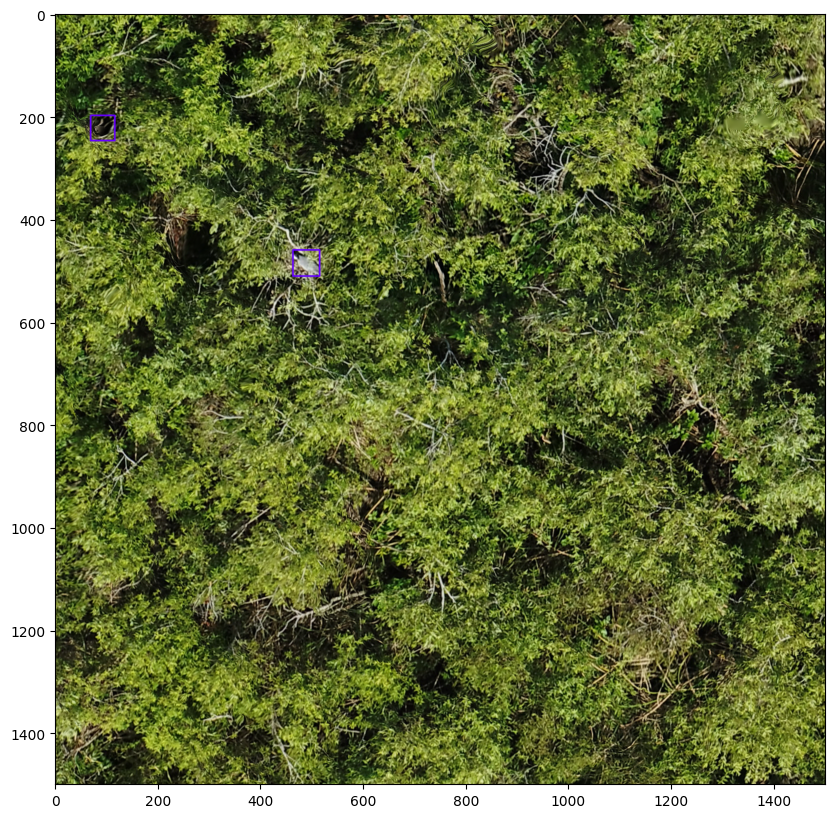

In [24]:
#Code Block 3 Simple upload of DeepForest annotations. 
from deepforest import main
from deepforest.visualize import plot_predictions
import matplotlib.pyplot as plt
import json
import PIL
import numpy as np

m = main.deepforest()
m.use_bird_release()

#Show an example
boxes = m.predict_image(path=crops[0])
boxes.head()

img = np.array(PIL.Image.open(crops[0]))

example_plot = plot_predictions(img, boxes, color=(100, 0, 255), thickness=2)
plt.figure(figsize=(10, 10))
plt.imshow(example_plot)
plt.show()

In this example, we have a typical scenerio for foundation models. Good, but not perfect performance. Remember, imperfect models can save humans a huge amount of time! Instead of carefully scanning through this image, we just need to delete one box and classify another. When applied to thousands of images, the time saved is massive.

In [19]:
predictions = []
for crop in crops:
    prediction = m.predict_image(path=crop)
    predictions.append(prediction)

## Upload to label-studio project

In [45]:

def label_studio_bbox_format(root_dir, preannotations):
    """Create a JSON string for a single image the Label Studio API.
    """
    predictions = []
    original_width = PIL.Image.open(os.path.join(root_dir,os.path.basename(preannotations.image_path.unique()[0]))).size[0]
    original_height = PIL.Image.open(os.path.join(root_dir,os.path.basename(preannotations.image_path.unique()[0]))).size[1]

    for index, row in preannotations.iterrows():
        result = {
            "value":{
                "x": row['xmin']/original_width*100,
                "y": row['ymin']/original_height*100,
                "width": (row['xmax'] - row['xmin'])/original_width*100,
                "height": (row['ymax'] - row['ymin'])/original_height*100,
                "rotation": 0,
                "rectanglelabels": [row["label"]]
            },
            "score": row["score"],
            "to_name": "image",
            "type": "rectanglelabels",
            "from_name": "label",
            "original_width": original_width,
            "original_height": original_height
        }
        predictions.append(result)
    # As a dict
    return {"result": predictions}

def import_image_tasks(label_studio_project,images,predictions,root_dir=None):
    """Upload images and predictions to a Label Studio project.
    Args:
    label_studio_project: A label studio project object
    images: A list of image paths. Must be absolute paths!
    predictions: A list of DeepForest predictions
    root_dir: The root directory of the images
    """

    # Get project
    tasks = []
    for image,prediction in zip(images, predictions):
        absolute_path = os.path.abspath(image)
        data_dict = {'image': os.path.join("/data/local-files/?d=/",absolute_path[1:])}
        if predictions:
            #Skip predictions if there are none
            if prediction.empty:
                result_dict = []
            else:
                result_dict = [label_studio_bbox_format(root_dir, prediction)]
            upload_dict = {"data":data_dict, "predictions":result_dict}
        tasks.append(upload_dict)
    label_studio_project.import_tasks(tasks)

# Use our helper function to upload the predictions and images
import_image_tasks(
    label_studio_project=existing_project,
    images=crops,
    predictions=predictions,
    root_dir="crops"
    )

After humans have reviewed and corrected these annotations, we can download them to train machine learning models using the web interface or label-studio’s python API.

## Converting among geospatial and image-based coordinates!

### Converting existing annotations from geospatial to image coordinates

What if we already have geospatial annotations? Very often, members of team will use common geospatial tools, such as ArcGIS or QGIS to draw annotations on to data products. One potential hurdle is transforming these geospatial coordinates into formats more commonly used by machine learning models. For example, to convert our existing annotations into the pixel coordinate plane, we want the 0,0 origin to be the top left corner, and the coordinates to be the row, column location. By providing the annotations and the corresponding RGB image, we can translate the geospatial to be expressed as pixels (row, columns). Note this an approximation that doesn't account for the curvature of the earth and is only useful on small spatial scales.

In [ ]:
import geopandas as gpd
import rasterio as rio
from shapely.geometry import Point

# Create a point geometry
point = Point(-80.539301043, 26.023538480)

# Create a GeoDataFrame with the point geometry
gdf = gpd.GeoDataFrame(geometry=[point])

# Set the coordinate reference system (CRS) if needed
gdf.crs = 'EPSG:4326'

with rio.open(image_path) as src:
    left, bottom, right, top = src.bounds
    image_resolution = src.res[0]
left, bottom, right, top = src.bounds
image_resolution = src.res[0]

gdf.geometry = gdf.geometry.translate(xoff=-left, yoff=-top)
gdf.geometry = gdf.geometry.scale(xfact=1/image_resolution, yfact=-1/image_resolution, origin=(0,0))
gdf.crs = None

gdf.head()

## Geospatial predictions from image-coordinates

Once we’ve made out predictions, we need to convert them back into geospatial coordinates to match our original data. This means going from boxes with image-based coordinates relative to the 0,0 origin to boxes with geospatial coordinates relative to the native map projection.  

In [ ]:
with rasterio.open(rgb_path) as dataset:
    bounds = dataset.bounds
    left, bottom, right, top = bounds
    pixelSizeX, pixelSizeY = dataset.res
    crs = dataset.crs

xmin_coords, ymin_coords = rasterio.transform.xy(transform=dataset.transform,
                                            rows=coordinates.miny,
                                            cols=coordinates.minx,
                                            offset='center')

xmax_coords, ymax_coords = rasterio.transform.xy(transform=dataset.transform,
                                            rows=coordinates.maxy,
                                            cols=coordinates.maxx,
                                            offset='center')

![final raster with geospatial predictions]()

## How to make this faster and more accurate?

Label studio’s open-source API opens the possibility for community driven development. We need your help! There are many ways to make annotation faster, which means more data, better models, and better information to make conservation decisions. We would welcome developers looking to make a difference to help make label-studio more ready for geospatial data.

1.	Allow overlays of multiple products. Often, we have several data types, such as RGB data, airborne multi-spectral data and LiDAR data that we want to look at in unison to help guide annotation. While this is possible in tools like QGIS, it is not natively doable in label-studio. 
2.	Intelligent zooming to annotations. Double clicking on the UI should zoom to a particular annotation, reducing costly scrolling time among objects. 
3. Improved backend integrations! The future of data labeling is interactive collaboration with foundation machine learning models. In the example above we preprocessed an image with a model and served the result to a person. An even better strategy is to take input from a person, then pass it to a model, and return it. This is starting to make its way into label-studio, with Meta's Segment-Anything model. A flavor of this model, called SAM-geo has been trained for remote sensing, and can be directly integrated into the server backend to provide segmentations based on prompts. These predicted annotations can then be quickly cleaned up by a human at a fraction of the total time needed to create polygon annotations. 


# Acknowlegements

The everglades bird survey gratefully acknowledges support from the South Florida Water Management District, US Army Corps of Engineers and University of Florida. Lindsey Gardner flew the UAV mission and Henry Senyondo processed the orthomosaic data. The DeepForest python package was supported by the National Science Foundation. The Weecology lab has no conflicts of interest or funding  